In [85]:
import random
import matplotlib.pyplot as plt
import concurrent.futures

# Hi-Lo Card Game

A card game where players guess if a certain face-up card is higher or lower in value than a certain face-down card!

## Game Logic

HiLoGame class:
1. Initializes the game with a specified number of decks (default is 1).
2. Creates and shuffles the deck of cards.
3. Provides methods to draw cards and compare them.
4. Implements the main game loop in the play method, which takes an agent's guess as an input each turn and returns the final score.

The longer a streak the agent has, the higher their score will be. The moment they make a wrong guess, they lose and their score is tallied.

In [86]:
class HiLoGame:
    def __init__(self, num_decks=1):
        self.num_decks = num_decks
        self.deck = self.create_deck()
        self.current_card = None

    #O(num_decks)
    def create_deck(self):
        suits = ['Hearts', 'Diamonds', 'Clubs', 'Spades']
        ranks = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'Jack', 'Queen', 'King', 'Ace']
        deck = [(rank, suit) for suit in suits for rank in ranks] * self.num_decks
        random.shuffle(deck)
        return deck

    #O(1)
    def draw_card(self):
        if len(self.deck) > 0:
            self.current_card = self.deck.pop()
            return self.current_card
        else:
            return None
        
    #O(1)
    def compare_cards(self, card1, card2):
        ranks = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'Jack', 'Queen', 'King', 'Ace']
        return ranks.index(card1[0]) < ranks.index(card2[0])

    #O(deck.size()) = O(1)
    def play(self, agent):
        score = 0
        self.current_card = self.draw_card()
    
        while self.current_card is not None:
            print(f"Current card: {self.current_card}")
            
            if isinstance(agent, MinimaxAgent) or isinstance(agent, MonteCarloAgent):
                guess = agent.make_guess(self.current_card, self.deck)
            else:
                guess = agent.make_guess(self.current_card)
            
            next_card = self.draw_card()
    
            if next_card is None:
                break
    
            print(f"Next card: {next_card}")
    
            if (guess == 'h' and self.compare_cards(self.current_card, next_card)) or \
               (guess == 'l' and not self.compare_cards(self.current_card, next_card)):
                score += 1
                print("Correct guess!")
            else:
                print("Incorrect guess.")
                break
    
            self.current_card = next_card
    
        print(f"Game over. Final score: {score}")
        return score

## Agents
### Random Agent

In [87]:
# Mainly used originally to debug the HiLo game logic 
class RandomAgent:
    #O(1)
    def make_guess(self, current_card):
        return random.choice(['h', 'l'])

### Minimax Agent

 A smart player who tries to make the best guess by thinking ahead. It looks at the current card and the remaining cards in the deck, and it imagines what could happen if it makes a certain guess.

In [88]:
class MinimaxAgent:
    def __init__(self, depth):
        self.depth = depth

    #O(2^depth)
    def make_guess(self, current_card, deck):
        _, guess = self.minimax(current_card, deck, self.depth, True)
        return guess

    #O(2^depth)
    def minimax(self, current_card, deck, depth, is_maximizing):
        if depth == 0 or len(deck) == 0:
            return 0, None
    
        if is_maximizing:
            max_score = float('-inf')
            best_guess = None
            for guess in ['h', 'l']:
                next_card = deck[0]
                next_deck = deck[1:]
                score = self.calculate_reward(current_card, next_card, guess)
                next_score, _ = self.minimax(next_card, next_deck, depth - 1, False)
                score += next_score
                if score > max_score:
                    max_score = score
                    best_guess = guess
            return max_score, best_guess
        else:
            min_score = float('inf')
            best_guess = None
            for guess in ['h', 'l']:
                next_card = deck[0]
                next_deck = deck[1:]
                score = self.calculate_reward(current_card, next_card, guess)
                next_score, _ = self.minimax(next_card, next_deck, depth - 1, True)
                score += next_score
                if score < min_score:
                    min_score = score
                    best_guess = guess
            return min_score, best_guess
        
    #O(1)
    def calculate_reward(self, current_card, next_card, guess):
        if (guess == 'h' and self.is_next_card_higher(current_card, next_card)) or \
           (guess == 'l' and not self.is_next_card_higher(current_card, next_card)):
            return 1
        else:
            return -1
        
    #O(1)
    def is_next_card_higher(self, card1, card2):
        ranks = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'Jack', 'Queen', 'King', 'Ace']
        return ranks.index(card1[0]) < ranks.index(card2[0])

### Monte Carlo Agent

Performs a specified number of simulations to estimate the probability of the next card being higher or lower than the current card. It shuffles the remaining deck in each simulation, draws the next card, and updates the win counts accordingly. Finally, it returns the guess based on which outcome (higher or lower) has more wins.

In [89]:
class MonteCarloAgent:
    def __init__(self, num_simulations):
        self.num_simulations = num_simulations

    #O(num_simulations*simulated_deck.size())
    def make_guess(self, current_card, deck):
        higher_wins = 0
        lower_wins = 0

        for _ in range(self.num_simulations):
            simulated_deck = deck[:]
            random.shuffle(simulated_deck)
            next_card = simulated_deck[0]

            if self.is_next_card_higher(current_card, next_card):
                higher_wins += 1
            else:
                lower_wins += 1

        if higher_wins > lower_wins:
            return 'h'
        else:
            return 'l'

    #O(1)
    def is_next_card_higher(self, card1, card2):
        ranks = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'Jack', 'Queen', 'King', 'Ace']
        return ranks.index(card1[0]) < ranks.index(card2[0])

## Playing the game

Run the line below to run and get a comparison of all the agents compared.

Current card: ('4', 'Spades')
Next card: ('King', 'Diamonds')
Incorrect guess.
Game over. Final score: 0
Current card: ('Queen', 'Diamonds')
Next card: ('6', 'Diamonds')
Correct guess!
Current card: ('6', 'Diamonds')
Next card: ('3', 'Clubs')
Incorrect guess.
Game over. Final score: 1
Current card: ('Ace', 'Hearts')
Next card: ('9', 'Clubs')
Incorrect guess.
Game over. Final score: 0
Current card: ('6', 'Clubs')
Next card: ('10', 'Spades')
Incorrect guess.
Game over. Final score: 0
Current card: ('7', 'Hearts')
Next card: ('Queen', 'Hearts')
Incorrect guess.
Game over. Final score: 0
Current card: ('4', 'Spades')
Next card: ('6', 'Spades')
Incorrect guess.
Game over. Final score: 0
Current card: ('9', 'Hearts')
Next card: ('Ace', 'Hearts')
Incorrect guess.
Game over. Final score: 0
Current card: ('7', 'Diamonds')
Next card: ('8', 'Diamonds')
Incorrect guess.
Game over. Final score: 0
Current card: ('Ace', 'Spades')
Next card: ('7', 'Spades')
Correct guess!
Current card: ('7', 'Spades')

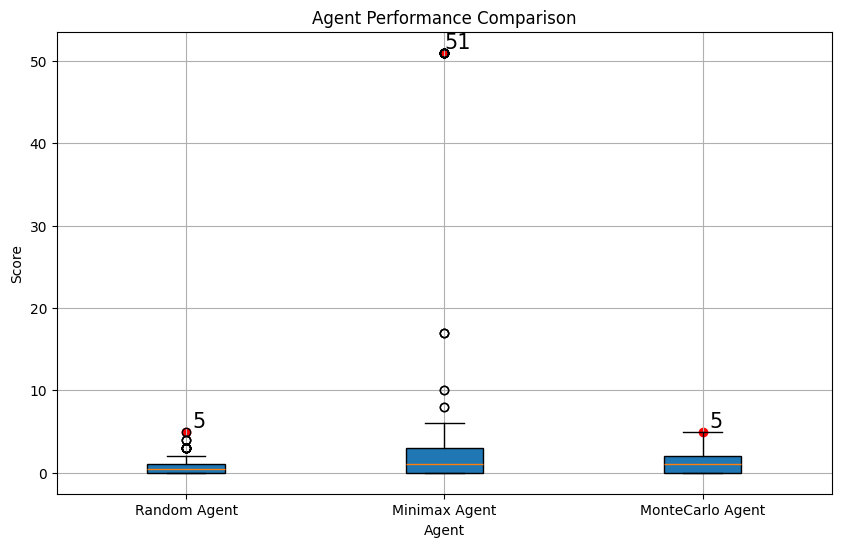

In [90]:
#O(num_games * decksize()) = O(num_games)
def run_simulation(num_games, agent):
    scores = []
    for i in range(num_games):
        game = HiLoGame()
        score = game.play(agent)
        scores.append(score)
    return scores

#O(num_agents * num_games)
def print_statistics(agent_scores):
    for agent_name, scores in agent_scores.items():
        num_games = len(scores)
        total_score = sum(scores)
        avg_score = total_score / num_games
        print(f"\nAgent: {agent_name}")
        print(f"Number of games played: {num_games}")
        print(f"Total score: {total_score}")
        print(f"Average score per game: {avg_score:.2f}")

#O(num_agents * num_games)
def compare_agents(num_games, agents):
    agent_scores = {}
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Schedule each agent to run in its own thread
        future_to_agent = {executor.submit(run_simulation, num_games, agent): agent_name for agent_name, agent in agents.items()}
        for future in concurrent.futures.as_completed(future_to_agent):
            agent_name = future_to_agent[future]
            scores = future.result()
            agent_scores[agent_name] = scores
    return agent_scores

# O(agent_scores.items().size())
def plot_agent_comparison(agent_scores):
    data = [scores for agent, scores in agent_scores.items()]
    plt.figure(figsize=(10, 6))
    plt.boxplot(data, labels=list(agent_scores.keys()), patch_artist=True)
    plt.xlabel('Agent')
    plt.ylabel('Score')
    plt.title('Agent Performance Comparison')
    plt.grid(True)
    
    # Add text annotations for the highest score of each agent
    for i, scores in enumerate(data):
        max_score = max(scores)
        plt.text(i + 1.05, max_score, f'{max_score}', ha='center', va='bottom', fontsize=15)
        plt.scatter(i + 1, max_score, color='red', marker='o')
    
    plt.show()

if __name__ == "__main__":
    num_games = 100  # Set the number of games to play
    agents = {
        'Random Agent': RandomAgent(),
        'MonteCarlo Agent': MonteCarloAgent(1000),
        'Minimax Agent': MinimaxAgent(10),
    }
    agent_scores = compare_agents(num_games, agents)
    print_statistics(agent_scores)
    plot_agent_comparison(agent_scores)

This report presents an analysis of two decision-making algorithms, Minimax without alpha-beta pruning and Monte Carlo Simulation, applied to the High-Low card game. The project aimed to evaluate the performance, strengths, and weaknesses of these algorithms in the context of a simple two-player, turn-based game with perfect information. 

## Purpose and Key Question

The primary purpose of this project was to gain a comprehensive understanding of decision-making strategies in the High-Low card game by comparing the performance of Minimax without alpha-beta pruning and Monte Carlo Simulation. The key question was: Which algorithm is more suitable for this game and potentially other similar games? 

## Experiment Design

The experiment evaluated Minimax without alpha-beta pruning and Monte Carlo Simulation algorithms in the High-Low card game. Game logic used an object-oriented approach with distinct agent classes: RandomAgent, MinimaxAgent, and MonteCarloAgent.

## Experiment Setup

The Hi-LoGame class managed game logic, initialized with a specified number of decks. Agents included RandomAgent for random guesses, MinimaxAgent using a recursive Minimax algorithm, and MonteCarloAgent employing Monte Carlo Simulation. The experiment ran multiple games (e.g., 100) for each agent concurrently using ThreadPoolExecutor. Scores were recorded for analysis. 

## Analysis

Our team has chosen to implement both Minimax without alpha-beta pruning and Monte Carlo Simulation for the High-Low card game. By comparing their performance and analyzing their strengths and weaknesses, we aim to gain a comprehensive understanding of decision-making in this game. [1]

Minimax without alpha-beta pruning serves as a baseline for optimal play under perfect information, while Monte Carlo Simulation allows us to explore the practicality and adaptability of a probabilistic approach. [2] By evaluating their performance in terms of win rate, computational efficiency, and scalability, we can make an informed decision on which algorithm is most suitable for the High-Low card game and potentially extend our findings to other similar games.

### Minimax without alpha-beta pruning:

Minimax is a decision-making algorithm commonly used in two-player, turn-based games with perfect information. It assumes that both players are playing optimally and tries to minimize the potential loss for a worst-case scenario.
In the context of the High-Low card game, using Minimax without alpha-beta pruning has the following quirks that we identified:

Game tree size: 
- The game tree for the High-Low card game is relatively small compared to more complex games like chess or Go. The depth of the game tree is limited by the number of cards in the deck, and the branching factor is only two (guessing "high" or "low"). This makes it feasible to explore the entire game tree using Minimax without running into significant performance issues.

Optimal play: 
- Minimax guarantees optimal play assuming the player is playing optimally. In the High-Low card game, the optimal strategy is based on the probability of the next card being higher or lower than the current card. Minimax can effectively evaluate these probabilities and make the best decision at each step.

Simplicity: 
- Implementing Minimax without alpha-beta pruning is relatively straightforward and easy to understand. It provides a solid foundation for decision-making in the High-Low card game without adding unnecessary complexity.

However, it's important to note that alpha-beta pruning is an optimization technique that can significantly reduce the number of nodes explored in the game tree without affecting the final result. In larger game trees, alpha-beta pruning becomes crucial for efficient computation. Since the game tree for the High-Low card game is small, the benefits of alpha-beta pruning may not be as significant. [3]

### Monte Carlo Simulation:

Monte Carlo Simulation is a probabilistic algorithm that relies on repeated random sampling to estimate the outcome of uncertain events. It is particularly useful when the problem space is large, and exhaustive exploration is infeasible.
In the context of the High-Low card game, using Monte Carlo Simulation has the following quirks that we identified:

Uncertainty: 
- The High-Low card game involves uncertainty due to the random shuffling of the deck. Monte Carlo Simulation can effectively handle this uncertainty by simulating multiple game playouts and estimating the probability of each outcome.

Sampling efficiency: 
- Monte Carlo Simulation can provide a good approximation of the optimal decision by sampling a sufficient number of game playouts. It doesn't require exploring the entire game tree, which can be advantageous when the game tree is large or the depth is unknown. [4]

Flexibility: 
- Monte Carlo Simulation can be easily adapted to different variations of the game or changes in the rules. It doesn't rely on a fixed game tree structure and can handle different scenarios effectively.

Parallelization: 
- Monte Carlo Simulation is inherently parallelizable since each game playout can be simulated independently. We did not take advantage of this since it would've added complexity to our already multithreaded runtime, and we were running out of time. This property could allow for efficient utilization of computational resources and can lead to faster convergence but would not improve individual runtime for each game played.

However, Monte Carlo Simulation has some limitations. It relies on random sampling, so the quality of the results depends on the number of simulations performed. More simulations generally lead to better approximations but also increase the computational cost. Additionally, Monte Carlo Simulation may not always provide the optimal decision, especially if the sample size is insufficient or the game tree is highly asymmetric. [5]


In the case of the High-Low card game, both Minimax without alpha-beta pruning and Monte Carlo Simulation can be effective approaches and that's why we chose them. Minimax provides optimal play but may be limited by the depth of the game tree, while Monte Carlo Simulation offers flexibility and handles uncertainty well but relies on sufficient sampling for accurate results.

## Comparison and Experimental Conclusion

The Minimax Agent without alpha-beta pruning emerged as the superior choice for the High-Low card game, providing optimal play and the highest average score. However, the Monte Carlo Agent demonstrated its flexibility and ability to handle uncertainty, making it a viable alternative, especially in larger or more complex games where exhaustive exploration is infeasible. 

## Lessons Learned

This project highlighted the importance of understanding the problem space and the trade-offs between different decision-making algorithms. While Minimax without alpha-beta pruning excelled in this specific game, the Monte Carlo Simulation approach showed promise in handling uncertainty and scalability, potentially making it more suitable for larger or more complex games. 

## Conclusion

The project successfully compared the performance of Minimax without alpha-beta pruning and Monte Carlo Simulation in the High-Low card game. The results demonstrated the strengths and weaknesses of each algorithm, providing insights into their applicability in different game scenarios. This knowledge can be extended to other turn-based games and decision-making problems, enabling informed choices about the most suitable algorithm based on the problem's characteristics. 

## References

[1] S. J. Russell, P. Norvig, and E. Davis, Artificial Intelligence: A Modern Approach, 3rd ed. Harlow, England: Pearson Education, 2022.​

[2] Geyer, W., Laurentiu, D., & Wehenkel, M. (2020). How to test decision-making algorithms safely. Ambiata Blog. https://ambiata.com/blog/2020-10-27-off-policy-evaluation/​

[3] Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction (2nd ed.). MIT Press.​

[4] Liu, H., Cojocaru, M., & Zhang, L. (2016, December). Performance evaluation system for decision tree algorithms. In 2016 International Symposium on Educational Technologies (ISET) (pp. 232-236).​

[5] Stehman, S. E. (2009). Selecting and interpreting measures of thematic classification accuracy. Remote Sensing of Environment, 113(10), 2105-2125. doi: 10.1016/j.rse.2009.04.001